# Analisi degli Spettrogrammi di Immagini Audio

In questo notebook viene eseguita un'analisi sugli spettrogrammi di alcuni audio. L'obiettivo è estrarre informazioni utili dagli spettrogrammi e rappresentarle graficamente. 

## Importazione delle librerie necessarie

Si installano e importano le librerie necessarie per l'analisi e la visualizzazione dei dati. 
Oltre a quelle già discusse durante il corso, verranno utilizzate le librerie scipy per l'estrazione di informazioni dagli audio e os per la navigazione all'interno delle directory del computer.

In [1]:
import numpy as np
import os, random
from scipy import signal
from scipy.io import wavfile
import matplotlib.pyplot as plt

## Funzioni Utilizzate 

Si andranno a creare le funzioni necessarie per l'analisi.

La prima funzione creata è `wav_to_spectr`, che si occupa di trasformare i file audio in formato .wav in spettrogrammi. 
Per farlo viene passata alla funzione il nome della classe che da cui si desidera estrarre l'immagine. Utilizza delle funzioni di scipy che, come precedentemente detto, ci permettono di estrarre le informazioni necessarie: un array di **frequenze espresse in Hz**, un array con la **durata in secondi** e lo spettrogramma. Infine, restituisce questi valori, indicando da quale file audio sono stati estratti e in quale cartella si trovava quel file.

In [2]:
def wav_to_spectr(dir_label):
    dir = "../reduced_dataset/dataset/audio/" # creiamo una variabile con il percorso del nostro dataset
    os.chdir(dir)
    os.chdir(dir_label) # entriamo in quella directory 
    audio = random.choice(os.listdir()) # scegliamo in modo randomico un audio all'interno della nostra cartella
    sample_rate, samples = wavfile.read(audio) # legge il file audio
    frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate) # creare lo spettrogramma
    os.chdir("../../../../speech-recognition-representation-unica-dl") # torniamo alla libreria dove è situato il nostro file jupyter
    return frequencies, times, spectrogram, audio, dir_label

La funzione `plot_spectrograms` racchiude tutti i comandi utili per la visualizzazione dei dati. Quando chiamata, utilizza la funzione precedentemente creata per estrarre le informazioni di quattro diversi audio.

In [3]:
def plot_spectrograms():
    frequencies_right1, times_right1, spectrogram_right1, audio_right1, dir_audio_right1 = wav_to_spectr('right') 
    frequencies_right2, times_right2, spectrogram_right2, audio_right2, dir_audio_right2 = wav_to_spectr('right')
    frequencies_tree1, times_tree1, spectrogram_tree1, audio_tree1, dir_audio_tree1 = wav_to_spectr('tree')
    frequencies_tree2, times_tree2, spectrogram_tree2, audio_tree2, dir_audio_tree2 = wav_to_spectr('tree')
    
    fig, ax = plt.subplots(2, 2, figsize=(12, 8))  # aumenta la dimensione della figura
    fig.tight_layout(pad=3.0)  # aggiungi padding tra i subplot
    
    # Primo spettrogramma
    ax[0, 0].pcolormesh(times_right1, frequencies_right1, np.log(spectrogram_right1))
    ax[0, 0].set_ylabel('Frequency [Hz]') 
    ax[0, 0].set_xlabel('Time [sec]')
    ax[0, 0].set_title("Classe: " + dir_audio_right2)
    
    # Secondo spettrogramma
    ax[0, 1].pcolormesh(times_right2, frequencies_right2, np.log(spectrogram_right2))
    ax[0, 1].set_ylabel('Frequency [Hz]') 
    ax[0, 1].set_xlabel('Time [sec]')
    ax[0, 1].set_title("Classe: " + dir_audio_right2)
    
    # Terzo spettrogramma
    ax[1, 0].pcolormesh(times_tree1, frequencies_tree1, np.log(spectrogram_tree1))
    ax[1, 0].set_ylabel('Frequency [Hz]') 
    ax[1, 0].set_xlabel('Time [sec]')
    ax[1, 0].set_title("Classe: " + dir_audio_tree2)
    
    # Quarto spettrogramma
    ax[1, 1].pcolormesh(times_tree2, frequencies_tree2, np.log(spectrogram_tree2))
    ax[1, 1].set_ylabel('Frequency [Hz]') 
    ax[1, 1].set_xlabel('Time [sec]')
    ax[1, 1].set_title("Classe: " + dir_audio_tree2)

    plt.show()

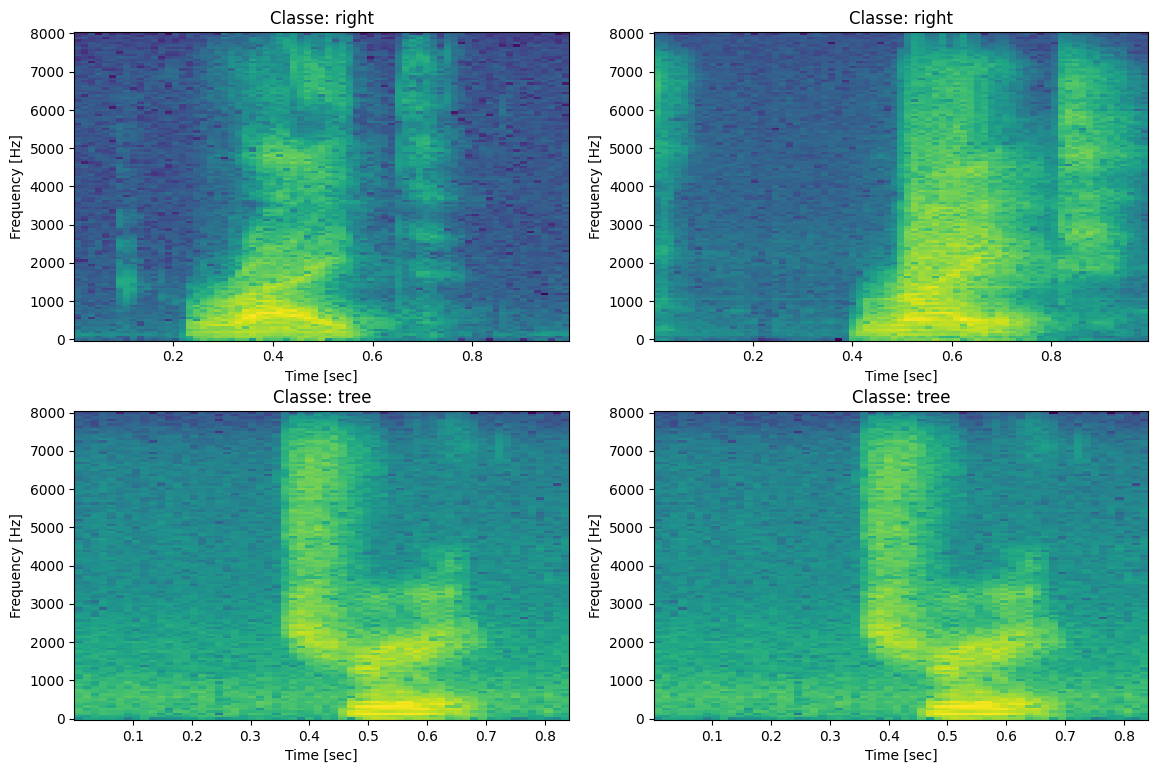

In [4]:
plot_spectrograms()

Vengono rappresentati gli spettrogrammi di due etichette diverse. Si può notare, anche ad occhio, come comandi appartenenti ad una stessa etichette abbiano frequenze simili, mentre quelli di classi diverse presentano differenze significative.